# Lab 03 Part 2 - Word Embeddings
In this lab we will look into word embeddings with word2vec and other similar methods

In [1]:
from IPython.display import HTML, display
colab_button = HTML(
    '<a target="_blank" href="https://colab.research.google.com/github/surrey-nlp/NLP-2026/blob/main/lab03/Lab03-Word-Embeddings-Solution.ipynb">'
    '<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>'
)
display(colab_button)

### Build your own
Let's start by first building our own word2vec model, instead of downloading a ready trained one. For that we are going to use the 20 news groups from sklearn, since is not too large for a lab exercise.

In [2]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data

# lets check the first two documents
documents[:2]

["Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one described in the\nletter have occured. The U.S. media as a whole seem to try to\nignore them. The U.S. is subsidizing Israels existance and the\nEuropeans are not (at least not to the same degree). So I think\nthat might be a reason they report more clearly on the\natrocities.\n\tWhat is a shame is that in Austria, daily reports of\nthe inhuman acts commited by Israeli soldiers and the blessing\nreceived from the Government makes some of the Holocaust guilt\ngo away. After all, look how the Jews are treating other races\nwhen they got power. It is unfortunate.\n",
 "\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap

The first thing to do is to format the documents into a list of sentences that contains a list of tokens. We are not going to do any further cleaning and pre-processing for now (to keep things simple for the labs), but that would be advisable.

In [3]:
from nltk.tokenize import sent_tokenize, word_tokenize

# This will take a minute or so
token_list = []
for d in documents:
    s = sent_tokenize(d) 
    token_list = token_list +[word_tokenize(t) for t in s]

# check the first three sentences
token_list[:3]

[['Well',
  'i',
  "'m",
  'not',
  'sure',
  'about',
  'the',
  'story',
  'nad',
  'it',
  'did',
  'seem',
  'biased',
  '.'],
 ['What',
  'I',
  'disagree',
  'with',
  'is',
  'your',
  'statement',
  'that',
  'the',
  'U.S.',
  'Media',
  'is',
  'out',
  'to',
  'ruin',
  'Israels',
  'reputation',
  '.'],
 ['That', 'is', 'rediculous', '.']]

Now is time to import the word2vec algorithm and set the key parameters

In [4]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.6/27.6 MB 27.5 MB/s eta 0:00:0000:0100:01


In [5]:
from gensim.models.word2vec import Word2Vec

# Number of vector elements (dimensions) to represent the word vector
num_features = 300
# Min number of word count to be considered in the Word2vec model. If your corpus is small, reduce the min count. If you’re training with a large corpus, increase the min count.
min_word_count = 1
# Number of CPU cores used for the training. If you want to set the number of cores dynamically, check out import multiprocessing: 
#num_workers = multiprocessing.cpu_count()
num_workers = 2
# Context window size
window_size = 3
# Subsampling rate for frequent terms
subsampling = 1e-3

Let's train the model!

In [6]:
%%time
model = Word2Vec(token_list, workers=num_workers, vector_size=num_features, min_count=min_word_count, window=window_size, sample=subsampling)

CPU times: user 38.9 s, sys: 374 ms, total: 39.3 s
Wall time: 21 s


Once you’ve trained your word model, you can reduce the memory footprint by about half if you freeze your model and discard the unnecessary information. The following command will discard the unneeded output weights of your neural network:

The model cannot be trained further once the weights of the output layer have been discarded.

Save the trained model with the following command and preserve it for later use:

In [7]:
model_name = "my_own_domain_specific_word2vec_model"
model.save(model_name)

Now lets say we want to load the model that we had previously saved.

In [8]:
from gensim.models.word2vec import Word2Vec
model_name = "my_own_domain_specific_word2vec_model"
model = Word2Vec.load(model_name)

Let's check the most similar words to "justice"

In [9]:
print(model.wv.most_similar('justice'))

[('abuse', 0.8987488746643066), ('blind', 0.893883466720581), ('race', 0.8913432955741882), ('reckless', 0.8865528702735901), ('social', 0.8862015604972839), ('democracy', 0.8823891282081604), ('divine', 0.8822439312934875), ('owning', 0.8774343729019165), ('organs', 0.8764327764511108), ('defence', 0.8750434517860413)]


### Challenge - 1
Try a few more words and observe if what is retrieved makes sense

### Using the gensim API
Having build our own model is great, but lets now load a model that was trained with MANY documents.

In [10]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

We will be using the downloader for the embedding models

In [11]:
import gensim.downloader as api

# this command can be used to check what models are available
api.info()

{'corpora': {'semeval-2016-2017-task3-subtaskBC': {'num_records': -1,
   'record_format': 'dict',
   'file_size': 6344358,
   'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/semeval-2016-2017-task3-subtaskB-eng/__init__.py',
   'license': 'All files released for the task are free for general research use',
   'fields': {'2016-train': ['...'],
    '2016-dev': ['...'],
    '2017-test': ['...'],
    '2016-test': ['...']},
   'description': 'SemEval 2016 / 2017 Task 3 Subtask B and C datasets contain train+development (317 original questions, 3,169 related questions, and 31,690 comments), and test datasets in English. The description of the tasks and the collected data is given in sections 3 and 4.1 of the task paper http://alt.qcri.org/semeval2016/task3/data/uploads/semeval2016-task3-report.pdf linked in section “Papers” of https://github.com/RaRe-Technologies/gensim-data/issues/18.',
   'checksum': '701ea67acd82e75f95e1d8e62fb0ad29',
   'file_name': 'se

Let's load the word2vec model from google news containing 300 features

In [12]:
# This will also take a few minutes to download the model and load it into memory
word2vec_model = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


Now check the embedding vector for "beautiful"... you will see a 300 dimensional vector

In [13]:
word2vec_model["beautiful"]

# The vector embedding values represent the numerical representation of the word "beautiful" in a 300-dimensional space learned by the Word2Vec model. 
# Each dimension of the vector corresponds to a feature or attribute of the word, which is learned by the model based on its co-occurrence patterns with 
# other words in a large text corpus.

array([-0.01831055,  0.05566406, -0.01153564,  0.07275391,  0.15136719,
       -0.06176758,  0.20605469, -0.15332031, -0.05908203,  0.22851562,
       -0.06445312, -0.22851562, -0.09472656, -0.03344727,  0.24707031,
        0.05541992, -0.00921631,  0.1328125 , -0.15429688,  0.08105469,
       -0.07373047,  0.24316406,  0.12353516, -0.09277344,  0.08203125,
        0.06494141,  0.15722656,  0.11279297, -0.0612793 , -0.296875  ,
       -0.13378906,  0.234375  ,  0.09765625,  0.17773438,  0.06689453,
       -0.27539062,  0.06445312, -0.13867188, -0.08886719,  0.171875  ,
        0.07861328, -0.10058594,  0.23925781,  0.03808594,  0.18652344,
       -0.11279297,  0.22558594,  0.10986328, -0.11865234,  0.02026367,
        0.11376953,  0.09570312,  0.29492188,  0.08251953, -0.05444336,
       -0.0090332 , -0.0625    , -0.17578125, -0.08154297,  0.01062012,
       -0.04736328, -0.08544922, -0.19042969, -0.30273438,  0.07617188,
        0.125     , -0.05932617,  0.03833008, -0.03564453,  0.24

Let's check some similar words to the word "girl"

In [14]:
word2vec_model.most_similar("girl")

[('boy', 0.8543271422386169),
 ('teenage_girl', 0.7927975654602051),
 ('woman', 0.7494640946388245),
 ('teenager', 0.7172499299049377),
 ('schoolgirl', 0.7075953483581543),
 ('teenaged_girl', 0.6650916337966919),
 ('daughter', 0.6489864587783813),
 ('mother', 0.6478164196014404),
 ('toddler', 0.6473966836929321),
 ('girls', 0.6154742240905762)]

How about some maths with vectors! Try the following:

queen - girl + boy = king

In [15]:
#positive=['boy', 'queen']: This is a list of two positive words 'boy' and 'queen' that will be used as reference to find similar words. The algorithm will try to find words that are closer to the positive words in the vector space.
#negative=['girl']: This is a list of one negative word 'girl' that will be used as reference to exclude from the search. The algorithm will try to find words that are farthest from the negative word in the vector space.
#topn=1: This parameter specifies the number of similar words to return. In this case, the function will return only one word that is most similar to the given positive and negative words.

word2vec_model.most_similar(positive=['boy', 'queen'], negative=['girl'], topn=1)

[('king', 0.7298421859741211)]

Time to do some visualisations and see how similar words end up close together and far from other words that are not as similar

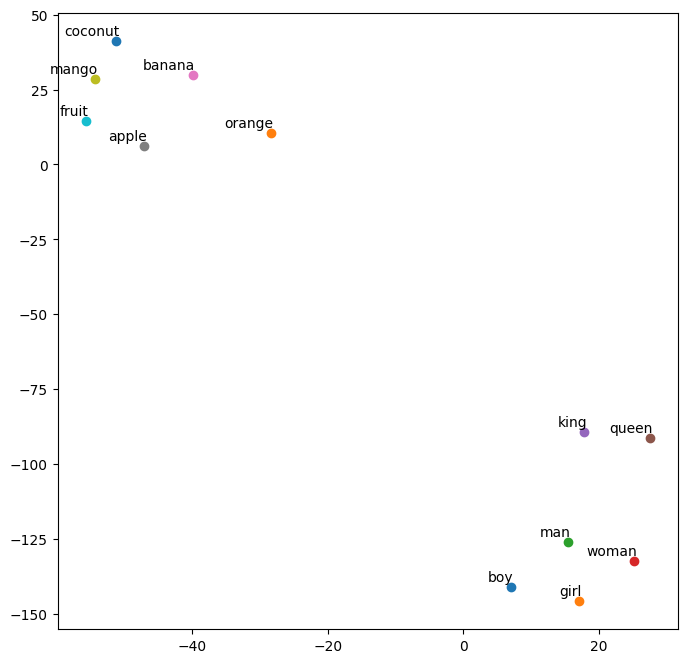

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

vocab = ["boy", "girl", "man", "woman", "king", "queen", "banana", "apple", "mango", "fruit", "coconut", "orange"]

def tsne_plot(model):
    labels = []
    wordvecs = []

    for word in vocab:
        wordvecs.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=3, n_components=2, init='pca', random_state=42)
    coordinates = tsne_model.fit_transform(np.array(wordvecs))

    x = []
    y = []
    for value in coordinates:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(8,8)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(2, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

tsne_plot(word2vec_model)


### Challenge - 2
Try a few more examples to visualise and see if similar words land close together

## GloVe
Let's try another model (GloVe) and see if that is any different to word2vec

In [17]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [18]:
import gensim.downloader as api
glove_model = api.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [19]:
glove_model["beautiful"]

array([-2.3852e-01, -3.3704e-01, -2.6531e-01, -3.4693e-01, -1.2875e-01,
        1.0698e-01, -2.4669e-02,  2.6829e-02, -1.0024e-01, -9.1494e-01,
        4.8989e-01, -1.0362e-01, -2.4535e-01,  5.7003e-01, -3.5189e-02,
       -3.7690e-01, -6.9177e-02, -2.5942e-01,  2.2511e-01,  5.1855e-01,
       -3.9326e-01,  1.2665e+00, -4.4396e-01,  7.6827e-01, -1.0909e-02,
       -2.4237e-01, -1.0275e-01, -4.9712e-01, -8.0183e-02,  4.0611e-01,
        2.1275e-01,  6.5182e-01, -1.1487e+00,  4.6080e-03, -6.8265e-01,
        9.6941e-01, -7.6194e-02, -4.1590e-01, -2.7069e-01, -5.3364e-02,
       -7.9631e-02, -2.6670e-01, -2.1544e-02,  2.2392e-01,  5.5741e-02,
        8.4611e-02,  8.6011e-01,  4.8927e-01,  4.7428e-01, -2.4446e-01,
       -2.1553e-01,  1.4370e-01,  5.0683e-01, -5.8435e-01, -5.6243e-01,
       -6.3757e-02, -2.2861e-01, -6.9374e-02,  5.6618e-01, -8.7813e-02,
       -2.1272e-01, -1.6319e-01,  3.3545e-01,  1.3707e-01, -1.1920e-03,
        9.7461e-02,  3.2382e-01, -2.2693e-01, -1.7767e-01,  4.01

It will be interesting to see if this will fins similar words to "girl" like word2vec did

In [20]:
glove_model.most_similar("girl")

[('boy', 0.8272891044616699),
 ('woman', 0.729641854763031),
 ('girls', 0.7227292060852051),
 ('teenager', 0.6509774327278137),
 ('teenage', 0.6492719054222107),
 ('mother', 0.6417974829673767),
 ('boys', 0.6283578872680664),
 ('child', 0.6229295134544373),
 ('teen', 0.612524151802063),
 ('daughter', 0.6050207614898682)]

Let's also see if it can solve the same analogy too

In [21]:
glove_model.most_similar(positive=['boy', 'queen'], negative=['girl'], topn=1)

[('king', 0.6770139932632446)]

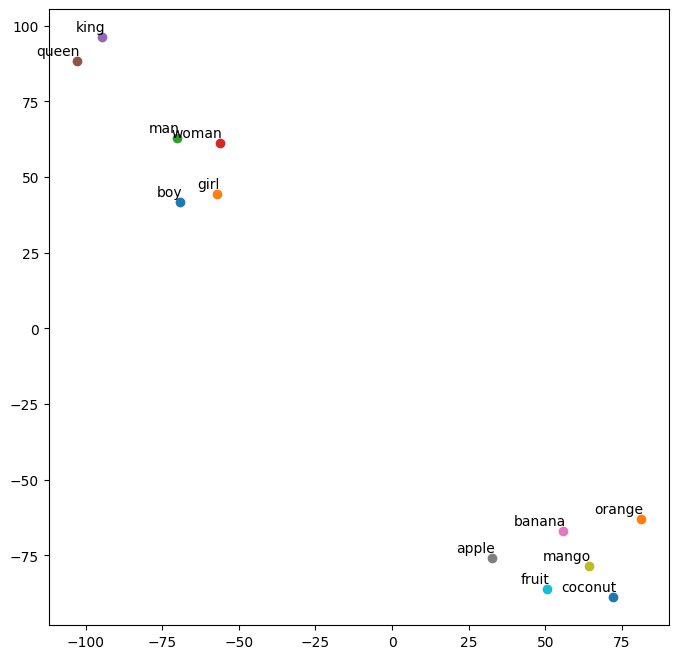

In [22]:
vocab = ["boy", "girl", "man", "woman", "king", "queen", "banana", "apple", "mango", "fruit", "coconut", "orange"]

def tsne_plot(model):
    labels = []
    wordvecs = []

    for word in vocab:
        wordvecs.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=3, n_components=2, init='pca', random_state=42)
    coordinates = tsne_model.fit_transform(np.array(wordvecs))

    x = []
    y = []
    for value in coordinates:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(8,8)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(2, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

tsne_plot(glove_model)

Let's continue with GloVe and check if plural words play any role in how close is to the original singular words

In [23]:
print(glove_model.distance("fruit", "fruits"))
print(glove_model.distance("girl", "girls"))
print(glove_model.distance("girl", "boy"))

0.17594563961029053
0.2772707939147949
0.17271089553833008


## Challenge - 3
Calculate the distance for "king" and "queen", then for "woman and "man". Is it similar? Check the plot to confirm.

Calculate the distance for "king" and "apple", then for "queen" and "apple". Is it similar again? Check the plot to confirm.

Now let's try and see if the model can find the capitals of different countries

In [24]:
import pandas as pd
# pretty print function
def pp(obj):
    print(pd.DataFrame(obj))
    
def analogy(worda, wordb, wordc):
    result = glove_model.most_similar(negative=[worda], positive=[wordb, wordc], topn=1)
    return result[0][0]

countries = ['australia', 'canada', 'germany', 'ireland', 'italy']
capitals = [analogy('usa', 'washington', country) for country in countries]
pp(zip(countries,capitals))

           0         1
0  australia  canberra
1     canada    ottawa
2    germany    berlin
3    ireland    dublin
4      italy      rome


## Challenge - 4
Looks good... but what if you change "usa" to "us"? Or if you used a different example to start with like "greece" and "athens"?

Now let's plot the results on a graph

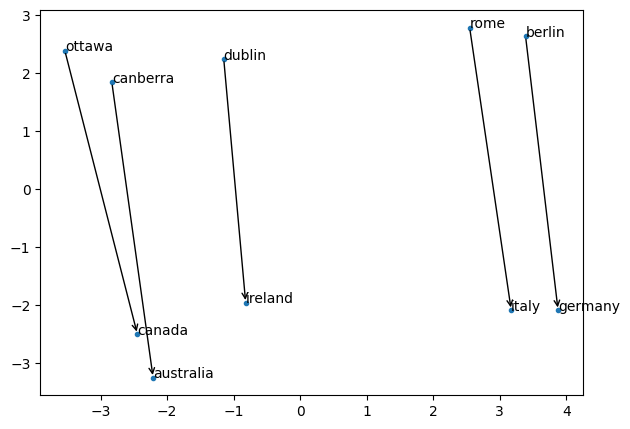

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def plot_data(orig_data, labels):
    pca = PCA(n_components=2)
    data = pca.fit_transform(orig_data)
    plt.figure(figsize=(7, 5), dpi=100)
    plt.plot(data[:,0], data[:,1], '.')
    for i in range(len(data)):
        plt.annotate(labels[i], xy = data[i])
    for i in range(len(data)//2):
        plt.annotate("",
                xy=data[i],
                xytext=data[i+len(data)//2],
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3")
        )
       
labels = countries + capitals
data = [glove_model[w] for w in labels]
plot_data(data, labels)

## FastText
Let's try another model (FastText) and see how it differs from Word2Vec and GloVe. FastText is particularly useful as it can generate embeddings for out-of-vocabulary words by using character n-grams.

In [26]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

Let's load the FastText model from Wikipedia containing 300 features

In [27]:
import gensim.downloader as api
# This will also take a few minutes to download the model and load it into memory
fasttext_model = api.load('fasttext-wiki-news-subwords-300')

[==================================================] 100.0% 958.5/958.4MB downloaded


Now check the embedding vector for "beautiful"

In [28]:
fasttext_model["beautiful"]

array([-0.005537  ,  0.001366  ,  0.02724   ,  0.0080048 ,  0.0091408 ,
       -0.0047591 , -0.02476   , -0.081426  , -0.033439  ,  0.0079388 ,
        0.0087009 , -0.059863  ,  0.034126  ,  0.010233  , -0.026814  ,
       -0.077423  ,  0.051773  , -0.0016141 ,  0.04852   ,  0.006607  ,
       -0.02531   , -0.020162  , -0.047592  ,  0.044361  ,  0.017669  ,
       -0.026539  ,  0.031816  ,  0.026875  ,  0.11173   , -0.00022543,
       -0.033134  , -0.006186  ,  0.0047593 , -0.061439  ,  0.04196   ,
        0.00048738,  0.030106  , -0.0057909 , -0.013756  , -0.010885  ,
        0.056878  , -0.096715  , -0.030501  , -0.054228  , -0.0054817 ,
       -0.031353  ,  0.010188  , -0.051661  ,  0.0049638 ,  0.061258  ,
       -0.020806  , -0.029995  , -0.060082  ,  0.011817  ,  0.0042355 ,
       -0.041362  ,  0.01488   , -0.027582  , -0.071135  , -0.00037955,
       -0.0056783 ,  0.0044044 ,  0.086884  ,  0.00067278,  0.049085  ,
        0.014035  , -0.025077  ,  0.019046  , -0.0015533 , -0.02

It will be interesting to see if this will find similar words to "girl" like the previous models did

In [29]:
fasttext_model.most_similar("girl")

[('boy', 0.8773636221885681),
 ('girl-', 0.8139981627464294),
 ('girl-girl', 0.7853878140449524),
 ('girly-girl', 0.779202938079834),
 ('girl-boy', 0.7781163454055786),
 ('schoolgirl', 0.7721588015556335),
 ('woman', 0.7577246427536011),
 ('girl.', 0.7567048668861389),
 ('girls', 0.7551297545433044),
 ('school-girl', 0.7514088749885559)]

Let's also see if it can solve the same analogy too

In [30]:
fasttext_model.most_similar(positive=['boy', 'queen'], negative=['girl'], topn=1)

[('king', 0.8088628053665161)]

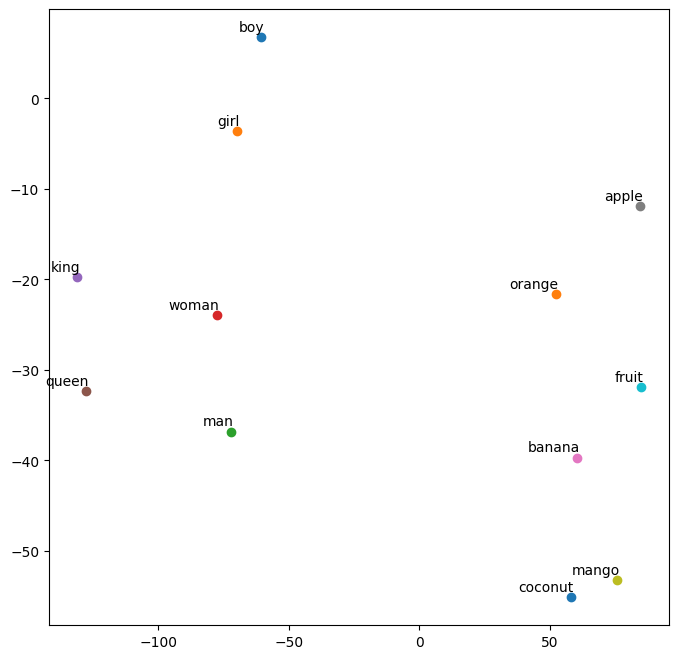

In [31]:
vocab = ["boy", "girl", "man", "woman", "king", "queen", "banana", "apple", "mango", "fruit", "coconut", "orange"]

def tsne_plot(model):
    labels = []
    wordvecs = []

    for word in vocab:
        wordvecs.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=3, n_components=2, init='pca', random_state=42)
    coordinates = tsne_model.fit_transform(np.array(wordvecs))

    x = []
    y = []
    for value in coordinates:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(8,8)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(2, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

tsne_plot(fasttext_model)

Let's compare distances between words using FastText and see how they differ from the other models

In [32]:
print(fasttext_model.distance("fruit", "fruits"))
print(fasttext_model.distance("girl", "girls"))
print(fasttext_model.distance("girl", "boy"))

0.1420101523399353
0.24487018585205078
0.12263649702072144


### Challenge - 5
One of the key advantages of FastText is that it can generate embeddings for out-of-vocabulary words. Try to get the embedding for a misspelled word like "beautifu" (missing the 'l'). Compare this with Word2Vec and GloVe - what happens? FastText should work better due to its character n-gram approach.

Also, try comparing the results you got from FastText with Word2Vec and GloVe for the same words and analogies. What differences do you notice?

In [33]:
# Test out-of-vocabulary word handling across all three models
print("=" * 70)
print("Testing Out-of-Vocabulary Word: 'nois' (missing 'e')")
print("=" * 70)

# Try with Word2Vec (this should fail for OOV words)
print("\n1. Word2Vec:")
try:
    w2v_vector = word2vec_model["nois"]
    print("   Found 'nois':", w2v_vector[:5])
except KeyError:
    print("   ERROR: Cannot find 'nois' - out of vocabulary word")

# Try with GloVe (this should fail for OOV words)
print("\n2. GloVe:")
try:
    glove_vector = glove_model["nois"]
    print("   Found 'nois':", glove_vector[:5])
except KeyError:
    print("   ERROR: Cannot find 'nois' - out of vocabulary word")

# Try with FastText (this should work!)
print("\n3. FastText:")
try:
    ft_vector = fasttext_model["nois"]
    print("   Found 'nois':", ft_vector[:5])
    print("\n   SUCCESS: FastText can handle out-of-vocabulary words!")
    print("   This is because FastText uses character n-grams, so even if a word")
    print("   is not in the training vocabulary, it can construct an embedding based")
    print("   on the character sequences it contains.")
except KeyError:
    print("   ERROR: Cannot find 'nois'")

Testing Out-of-Vocabulary Word: 'nois' (missing 'e')

1. Word2Vec:
   ERROR: Cannot find 'nois' - out of vocabulary word

2. GloVe:
   ERROR: Cannot find 'nois' - out of vocabulary word

3. FastText:
   Found 'nois': [ 0.081627  -0.062855   0.020061   0.022017  -0.0076474]

   SUCCESS: FastText can handle out-of-vocabulary words!
   This is because FastText uses character n-grams, so even if a word
   is not in the training vocabulary, it can construct an embedding based
   on the character sequences it contains.


In [34]:
# Test with another misspelled word
print("\n" + "=" * 70)
print("Testing Another Out-of-Vocabulary Word: 'gril' (misspelled 'girl')")
print("=" * 70)

print("\n1. Word2Vec:")
try:
    w2v_vector = word2vec_model["gril"]
    print("   Found 'gril':", w2v_vector[:5])
except KeyError:
    print("   ERROR: Cannot find 'gril'")

print("\n2. GloVe:")
try:
    glove_vector = glove_model["gril"]
    print("   Found 'gril':", glove_vector[:5])
except KeyError:
    print("   ERROR: Cannot find 'gril'")

print("\n3. FastText:")
try:
    ft_vector = fasttext_model["gril"]
    print("   Found 'gril':", ft_vector[:5])
    print("   SUCCESS: FastText handles 'gril' gracefully!")
except KeyError:
    print("   ERROR: Cannot find 'gril'")

# Summary
print("\n" + "=" * 70)
print("SUMMARY OF KEY DIFFERENCES:")
print("=" * 70)
print("\nWord2Vec & GloVe:")
print("  - Cannot handle out-of-vocabulary (OOV) words")
print("  - Will raise KeyError if word not in training vocabulary")
print("  - Limited to words seen during training")

print("\nFastText:")
print("  - CAN handle out-of-vocabulary words!")
print("  - Uses character n-grams to represent words")
print("  - Even unseen or misspelled words get meaningful embeddings")
print("  - Better for morphologically rich languages and typos")
print("\nThis demonstrates why FastText is more robust for real-world applications!")


Testing Another Out-of-Vocabulary Word: 'gril' (misspelled 'girl')

1. Word2Vec:
   Found 'gril': [ 0.00469971  0.03369141 -0.0859375   0.00747681 -0.05688477]

2. GloVe:
   ERROR: Cannot find 'gril'

3. FastText:
   Found 'gril': [-0.030185 -0.027165 -0.034991  0.018959 -0.019715]
   SUCCESS: FastText handles 'gril' gracefully!

SUMMARY OF KEY DIFFERENCES:

Word2Vec & GloVe:
  - Cannot handle out-of-vocabulary (OOV) words
  - Will raise KeyError if word not in training vocabulary
  - Limited to words seen during training

FastText:
  - CAN handle out-of-vocabulary words!
  - Uses character n-grams to represent words
  - Even unseen or misspelled words get meaningful embeddings
  - Better for morphologically rich languages and typos

This demonstrates why FastText is more robust for real-world applications!


### Connection to Subword Tokenization (from Lab 2)

You may recall from Lab 2 that we explored different tokenization techniques, including **subword tokenization** methods like Byte Pair Encoding (BPE) and WordPiece. FastText shares a fundamental concept with these approaches - it also operates at the **character and subword level**.

Unlike Word2Vec and GloVe which treat each word as an atomic unit and cannot handle out-of-vocabulary words, FastText represents each word as a **collection of character n-grams**. This is conceptually similar to how subword tokenization breaks words into meaningful subunits:

- **Subword Tokenization (Lab 2)**: Breaks words into subword units like BPE tokens or WordPiece tokens
- **FastText**: Breaks words into character n-grams (e.g., "beautiful" = "<b", "be", "ea", "au", "ut", "ti", "if", "fu", "ul", "l>")

This shared principle allows FastText to:
1. Handle misspelled or out-of-vocabulary words by composing embeddings from known character n-grams
2. Better understand morphologically similar words (e.g., "run", "running", "runs" share character n-grams)
3. Generalize better to rare or unseen words that share common subword patterns

This demonstrates an important concept in NLP: **representation at multiple levels of granularity** (character, subword, word, and sentence) is often more powerful than single-level approaches!

## doc2vec
Now let's look into generating feature vectors for documents instead of just words. For that we are going to use word2vec

In [35]:
import multiprocessing
num_cores = multiprocessing.cpu_count()

from gensim.models.doc2vec import TaggedDocument,Doc2Vec
from gensim.utils import simple_preprocess

First let's load some data

In [36]:
corpus = dataset.data

training_corpus = []
for i, text in enumerate(corpus):
    tagged_doc = TaggedDocument(simple_preprocess(text), [i])
    training_corpus.append(tagged_doc)
    
# If you’re running low on RAM, and you know the number of documents ahead of time (your corpus object isn’t an iterator or generator),
# you might want to use a preallocated numpy array instead of Python list for your training_corpus:
#training_corpus = np.empty(len(corpus), dtype=object);
#… 
#training_corpus[i] = …

Now we will build the model and train it

In [37]:
doc2vec_model = Doc2Vec(vector_size=100, min_count=2, workers=num_cores, epochs=10)
doc2vec_model.build_vocab(training_corpus)
doc2vec_model.train(training_corpus, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

In [38]:
doc2vec_model_2 = Doc2Vec(vector_size=300, min_count=2, workers=num_cores, epochs=10)
doc2vec_model_2.build_vocab(training_corpus)
doc2vec_model_2.train(training_corpus, total_examples=doc2vec_model_2.corpus_count, epochs=doc2vec_model_2.epochs)

In [39]:
doc2vec_model_3 = Doc2Vec(vector_size=100, min_count=2, workers=num_cores, epochs=20)
doc2vec_model_3.build_vocab(training_corpus)
doc2vec_model_3.train(training_corpus, total_examples=doc2vec_model_3.corpus_count, epochs=doc2vec_model_3.epochs)

In [40]:
doc2vec_model_4 = Doc2Vec(vector_size=300, min_count=2, workers=num_cores, epochs=20)
doc2vec_model_4.build_vocab(training_corpus)
doc2vec_model_4.train(training_corpus, total_examples=doc2vec_model_4.corpus_count, epochs=doc2vec_model_4.epochs)

Time to generate the feature vector of a new document!

In [41]:
doc_vector = doc2vec_model.infer_vector(simple_preprocess('This is a completely unseen document'), epochs=10)
doc_vector

array([-0.08111017,  0.02723565,  0.03948283,  0.03374864, -0.02530845,
       -0.12903573,  0.05646377, -0.00749249, -0.10112701, -0.1231523 ,
        0.0355569 , -0.10693167, -0.01975271, -0.05746081, -0.00693303,
        0.05980163,  0.00557467, -0.07176973, -0.00280897, -0.0420192 ,
       -0.01971068, -0.04615869,  0.06756467, -0.08051706, -0.05616583,
       -0.05325332, -0.05312133, -0.03560413,  0.03849801,  0.02564415,
        0.02554136, -0.02126966,  0.08721267, -0.04085762,  0.04421104,
        0.132965  , -0.02738901,  0.10703731, -0.1533847 , -0.04329281,
        0.02093242, -0.02739826,  0.0882886 , -0.03179654, -0.02346344,
       -0.15500192, -0.06271918,  0.06298582,  0.01728113, -0.05366357,
       -0.07926133, -0.12258855,  0.07094005,  0.00732589, -0.06932273,
       -0.10558534,  0.08059241,  0.03885641,  0.03681336,  0.00538706,
        0.04236746, -0.07915518, -0.02732428, -0.03023462, -0.10287397,
        0.12302909,  0.11233384,  0.06564829, -0.14602628, -0.01

In [42]:
doc_vector = doc2vec_model_2.infer_vector(simple_preprocess('This is a completely unseen document'), epochs=10)
doc_vector

array([ 5.94477877e-02,  4.93919924e-02,  3.51719856e-02,  7.11990446e-02,
       -2.43283231e-02, -4.90631759e-02,  5.80782490e-03,  4.78411876e-02,
        1.76138598e-02, -5.38601279e-02, -2.40094345e-02, -1.60401836e-02,
       -7.82676935e-02,  6.50377646e-02, -2.45543811e-02,  1.92859937e-02,
        2.84874495e-02, -1.41329784e-02, -1.73846874e-02, -4.10683267e-02,
        1.61002446e-02,  1.65817589e-02, -2.35036630e-02, -3.35716605e-02,
        6.12944700e-02,  4.53789392e-03, -9.45158824e-02,  2.26169322e-02,
       -1.02858907e-02,  3.50964465e-03,  1.97240580e-02, -4.72032931e-03,
        2.70024072e-02,  4.72077616e-02,  1.24724060e-02, -1.51756825e-02,
        3.34240049e-02, -3.47522758e-02,  6.68686815e-03,  3.87675781e-03,
       -3.24641578e-02, -3.11534237e-02,  1.66716725e-02, -4.67994995e-02,
        1.52254505e-02,  8.32291320e-03, -2.95430887e-03,  6.98655099e-02,
       -4.90945354e-02, -3.38836685e-02,  1.47548160e-02, -1.24490540e-03,
        7.91688077e-03,  

In [43]:
doc_vector = doc2vec_model_3.infer_vector(simple_preprocess('This is a completely unseen document'), epochs=20) # Use the increased number of epochs
doc_vector

array([-0.0573425 , -0.06442214,  0.04355323, -0.11170094, -0.13211212,
       -0.27695766,  0.22090274,  0.03831188, -0.20574984, -0.32199666,
       -0.12338245, -0.15603846, -0.08774334,  0.08355145,  0.00259731,
        0.10563409, -0.01569359, -0.33763894,  0.02806141, -0.18424106,
        0.0942883 ,  0.09674779,  0.03042032, -0.05832058, -0.11634944,
        0.11799441, -0.2583413 , -0.01305269, -0.01015188, -0.10404462,
       -0.10234576, -0.1655947 ,  0.10356496,  0.12787293, -0.09595046,
        0.16199623,  0.06443916, -0.14248155, -0.25317347, -0.17948438,
       -0.0241114 , -0.17062551,  0.14795893,  0.06512863, -0.14726608,
       -0.22826496,  0.00296175,  0.11088403,  0.03865521,  0.04673404,
        0.03570037, -0.3108047 ,  0.13780469, -0.14196545, -0.03989151,
       -0.07329056, -0.049144  , -0.12086333, -0.02526276,  0.10153418,
       -0.08701299, -0.00182857,  0.0215693 , -0.11429419, -0.2913542 ,
        0.20906165,  0.1095622 ,  0.11346521, -0.2584957 ,  0.18

In [44]:
doc_vector = doc2vec_model_4.infer_vector(simple_preprocess('This is a completely unseen document'), epochs=20) # Use the increased number of epochs
doc_vector

array([ 8.51769894e-02,  7.63072520e-02,  1.16650589e-01,  1.05720215e-01,
       -5.23558110e-02,  2.41532847e-02, -2.06600409e-02,  1.49327010e-01,
        1.27028581e-02, -9.52030942e-02, -8.11211169e-02, -5.54317683e-02,
       -1.19261175e-01,  7.60174021e-02,  3.88327949e-02,  5.87189980e-02,
        5.26271537e-02, -2.46262830e-02,  2.03384832e-02, -7.72046596e-02,
        8.04396160e-03,  3.33367400e-02, -3.72695713e-03, -3.44754197e-03,
        7.33483657e-02,  2.05644164e-02, -1.25102311e-01,  4.77018766e-02,
        5.49830385e-02, -5.17684184e-02,  7.98970908e-02, -3.63664851e-02,
        1.24294059e-02,  1.41805872e-01,  2.05274317e-02, -2.64587160e-02,
       -1.36982501e-01, -1.01019517e-01,  5.02896048e-02, -4.60204147e-02,
       -1.03864828e-02, -1.31226080e-02,  2.26334855e-02, -5.78885116e-02,
       -2.41854172e-02,  1.08498417e-01, -9.07948464e-02,  1.63876593e-01,
       -2.10349783e-02, -3.54629345e-02,  1.27569646e-01,  9.10429209e-02,
       -5.34865893e-02,  

Time to generate the feature vector of a new document! In this instance I just chose an existing one (i.e. the first one).

In [45]:
doc_vector = doc2vec_model.infer_vector(simple_preprocess(dataset.data[0]), epochs=10)
doc_vector

array([-0.1714218 ,  0.033041  ,  0.46050465, -0.01678455, -0.21933073,
       -0.02529148, -0.04746426,  0.06648877, -0.520682  , -0.37061718,
        0.10492647,  0.20745127, -0.3498123 ,  0.05957703,  0.38365638,
        0.14835533,  0.0186703 , -0.40329278,  0.11778199, -0.03499651,
        0.07200583,  0.1618674 ,  0.12894717, -0.61791575, -0.13497092,
       -0.41501105,  0.08928204,  0.08378498,  0.34433454, -0.06973954,
       -0.2170248 , -0.33089355,  0.25309497, -0.22096989,  0.2539714 ,
        0.24305485,  0.20648399,  0.07603806,  0.26565263,  0.22055663,
       -0.4504291 ,  0.14046133,  0.76922435, -0.24488199, -0.10476643,
       -0.86136687, -0.09619974,  0.68033814,  0.07403772, -0.41141412,
       -0.39446408, -0.34878984,  0.19042222,  0.13010213, -0.02747838,
       -0.3368335 ,  0.09884018,  0.22097895,  0.09539746,  0.15306868,
       -0.31883067,  0.26952887, -0.17783913, -0.15427165, -0.28222165,
        0.52254575,  0.34099972, -0.21273245, -0.47166333,  0.10

I will now try to find the most similar documents. This will return the index of the most similar docs. Since I used an existing document as in input, I am expecting this (i.e. index 0) to be the best match.

In [46]:
doc2vec_model.docvecs.most_similar([doc_vector])

/tmp/ipykernel_3113953/796245999.py:1: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  doc2vec_model.docvecs.most_similar([doc_vector])


[(0, 0.9026117324829102),
 (898, 0.7562594413757324),
 (7622, 0.7520542144775391),
 (3580, 0.7507201433181763),
 (2127, 0.7367487549781799),
 (9530, 0.7352646589279175),
 (7266, 0.7302312254905701),
 (771, 0.7302020788192749),
 (5866, 0.7275508046150208),
 (3329, 0.7242757678031921)]

Now lets check the two most similar documents and see if there is similarity in the context.

In [47]:
print(" *** Doc 1 ***")
print(dataset.data[0])
print(" *** Doc 2 ***")
print(dataset.data[3580])

 *** Doc 1 ***
Well i'm not sure about the story nad it did seem biased. What
I disagree with is your statement that the U.S. Media is out to
ruin Israels reputation. That is rediculous. The U.S. media is
the most pro-israeli media in the world. Having lived in Europe
I realize that incidences such as the one described in the
letter have occured. The U.S. media as a whole seem to try to
ignore them. The U.S. is subsidizing Israels existance and the
Europeans are not (at least not to the same degree). So I think
that might be a reason they report more clearly on the
atrocities.
	What is a shame is that in Austria, daily reports of
the inhuman acts commited by Israeli soldiers and the blessing
received from the Government makes some of the Holocaust guilt
go away. After all, look how the Jews are treating other races
when they got power. It is unfortunate.

 *** Doc 2 ***
	First let me correct myself in that it was Goerbels and
not Goering (Airforce) who ran the Nazi propaganda machine. 

## Challenge - 5
Use the fetch_20newsgroups dataset from sklearn (see code above) and re-train doc2vec with that data instead.

Then, check using the most similar function to see if the documents you test are indeed similar.